In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])

In [3]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands
0,2022-01-01,36,2201.722967,56208.538497,4342
1,2022-01-02,11,-164.573991,48039.620299,3836
2,2022-01-03,12,-147.260111,19233.123874,1630
3,2022-01-04,10,1064.457361,61688.730570,1664
4,2022-01-05,16,1601.138453,28191.484771,2257


<Axes: xlabel='Date'>

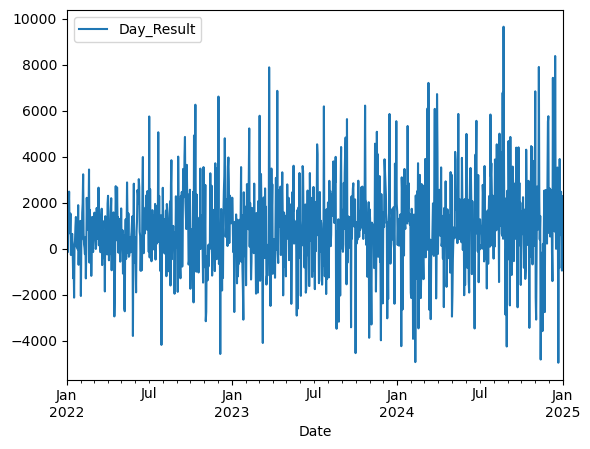

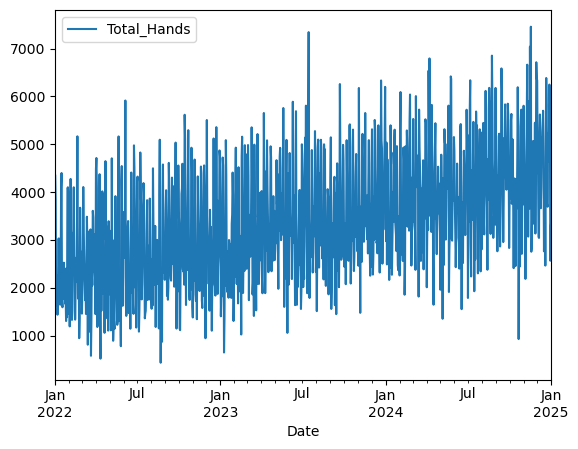

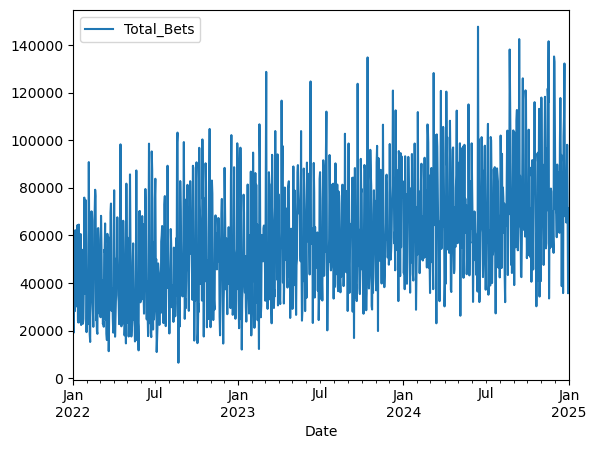

In [4]:
casino_fig[:].plot(x="Date", y ="Day_Result")
casino_fig[:].plot(x="Date", y ="Total_Hands")
casino_fig[:].plot(x="Date", y ="Total_Bets")


## Приемы для анализа ряда

#### Скользящее среднее окно



[pandas.Series.rolling.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.rolling.html)

``` python
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()
```

In [5]:
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()

<Axes: xlabel='Date'>

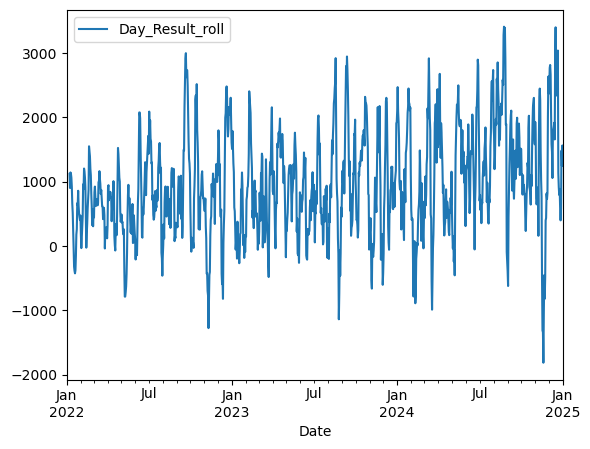

In [6]:
casino_fig.plot(x="Date", y ="Day_Result_roll")


#### Скользим по медианам

[scipy.signal.medfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html)


```python
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=7)
```

In [7]:
from scipy.signal import medfilt

In [8]:
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=7)

<Axes: xlabel='Date'>

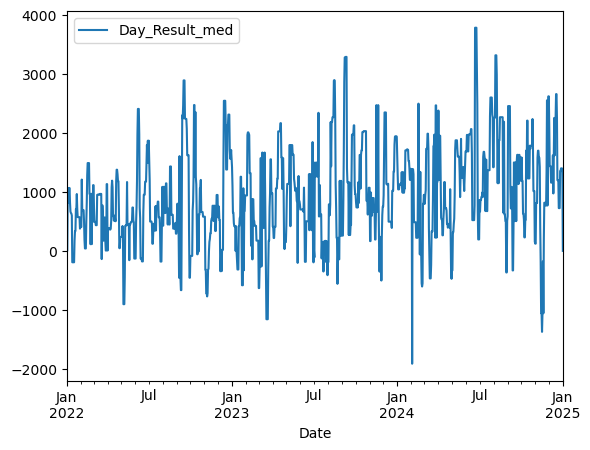

In [9]:
casino_fig.plot(x="Date", y ="Day_Result_med")

## Экспон-е сглаживание

[pandas.Series.ewm](https://pandas.pydata.org/docs/reference/api/pandas.Series.ewm.html)

```python
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()

```


In [10]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()


<Axes: xlabel='Date'>

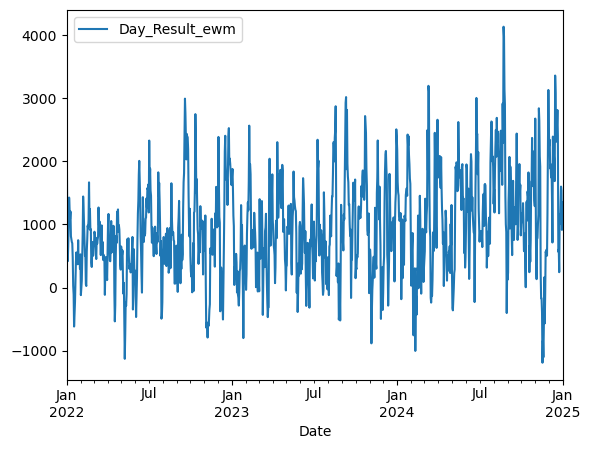

In [11]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [12]:
casino_fig['Total_Bets_ewm'] = casino_fig['Total_Bets'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

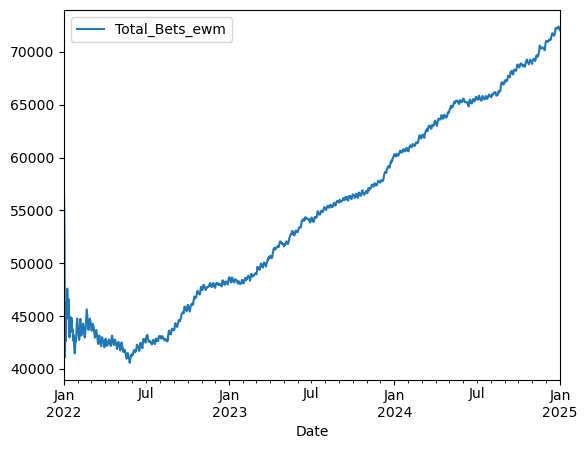

In [13]:
casino_fig.plot(x="Date", y ="Total_Bets_ewm")


### Линейная аппроксимация

[scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)


In [14]:
from scipy import stats

In [15]:
slope, intercept, r, p, std_err = stats.linregress(casino_fig.index,casino_fig['Total_Bets'])

In [18]:
casino_fig['trend_bet']= slope*casino_fig.index+intercept

<Axes: xlabel='Date'>

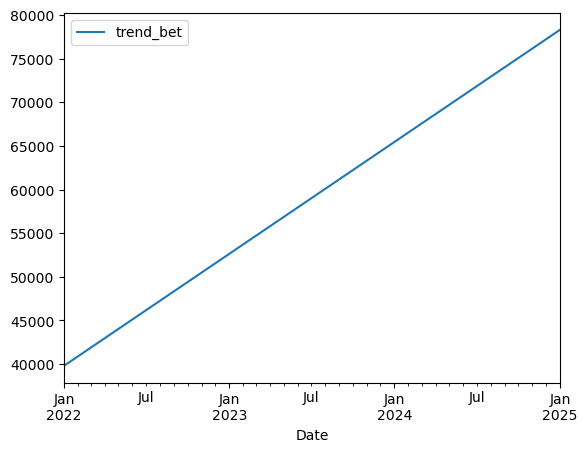

In [19]:
casino_fig.plot(x="Date", y ="trend_bet")

In [20]:
casino_fig['trend_free'] = casino_fig['Total_Bets']-casino_fig['trend_bet'] + intercept

<Axes: xlabel='Date'>

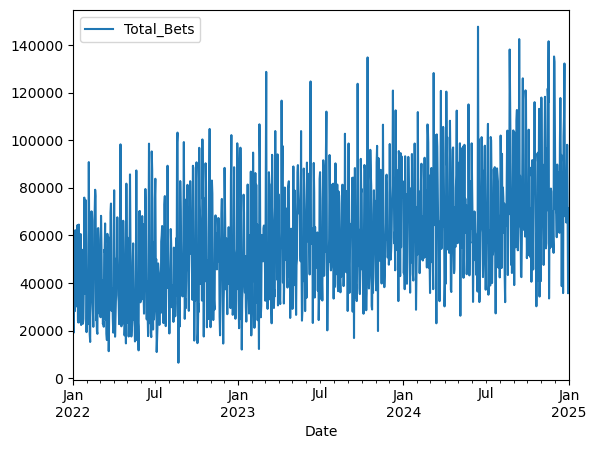

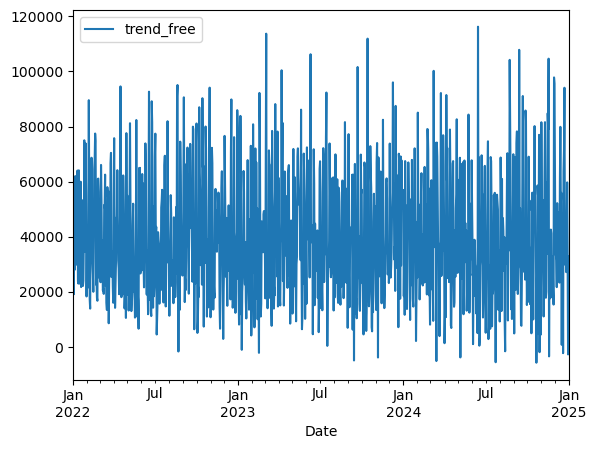

In [46]:
casino_fig.plot(x="Date", y ="Total_Bets")
casino_fig.plot(x="Date", y ="trend_free")

### Аппроксимация многочленом

`np.polyfit`

— это функция в библиотеке NumPy для Python, которая находит коэффициенты полинома степени 𝑛 , наилучшим образом соответствующего набору данных (𝑥,𝑦)  
с использованием метода наименьших квадратов.

In [53]:
# Perform cubic fit
coefficients = np.polyfit(casino_fig.index,casino_fig['Total_Bets'], 1)
print(coefficients)

[3.51176518e+01 3.98161707e+04]


In [54]:
p = np.poly1d(coefficients) # создаём полином

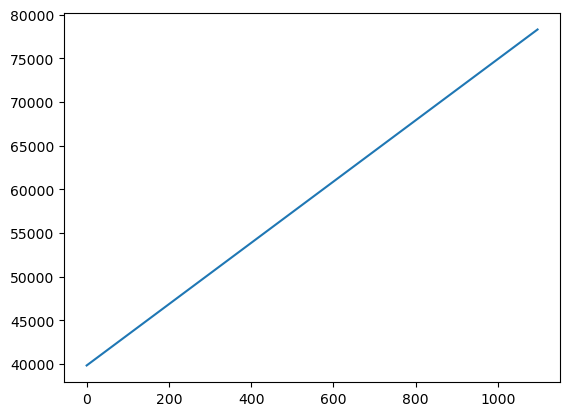

In [55]:
plt.plot(casino_fig.index,p(casino_fig.index))

### Самый простой способ анализа временного ряда с сезоностью.

In [26]:
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek 

In [27]:
casino_fig['week_day']

0       5
1       6
2       0
3       1
4       2
       ..
1092    5
1093    6
1094    0
1095    1
1096    2
Name: week_day, Length: 1097, dtype: int32

#### Группируем по дням недели.


In [28]:
casino_fig.groupby('week_day')['trend_free'].mean()

week_day
0    21653.606954
1    28448.789929
2    30854.675539
3    25514.821580
4    61834.464963
5    61326.730570
6    49129.257967
Name: trend_free, dtype: float64

In [29]:
bet_df =casino_fig.groupby('week_day')['trend_free'].agg([ 'mean','std'])

### по каждому дню находим СКО

In [56]:
bet_df['low_res'] = bet_df['mean'] - 2* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 2* bet_df['std']

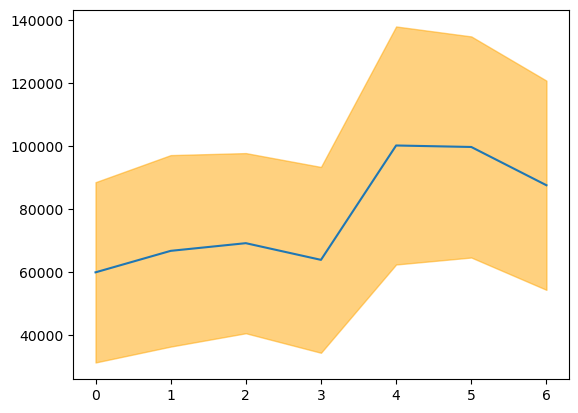

In [57]:
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')

In [32]:
bet_df.index

Index([0, 1, 2, 3, 4, 5, 6], dtype='int32', name='week_day')

In [33]:
casino_fig.tail(10)

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm,Total_Bets_ewm,trend_bet,trend_free,week_day
1087,2024-12-23,21,724.183937,78233.033562,3753,914.632463,724.183937,606.771218,72264.649665,77989.058210,40060.146064,0
1088,2024-12-24,27,-843.490836,68007.382989,3693,794.939735,724.183937,244.205705,72241.326168,78024.175862,29799.377839,1
1089,2024-12-25,22,3897.478583,73032.806736,5226,886.047019,724.183937,1157.523924,72245.662245,78059.293514,34789.683934,2
1090,2024-12-26,27,591.229817,65455.137842,4638,591.191402,1347.691552,1015.950397,72208.461300,78094.411166,27176.897389,3
1091,2024-12-27,35,2183.161807,78438.128191,5197,399.112853,1347.691552,1307.753250,72242.589191,78129.528817,40124.770086,4
1092,2024-12-28,40,2475.025873,98094.783054,6247,581.559855,1397.791652,1599.571406,72384.212923,78164.646469,59746.307297,5
1093,2024-12-29,32,1347.691552,72015.606719,5885,1482.182962,1397.791652,1536.601442,72382.193649,78199.764121,33632.013310,6
1094,2024-12-30,21,-952.472529,35732.841144,2564,1242.660610,1397.791652,914.332949,72181.426318,78234.881773,-2685.869917,0
1095,2024-12-31,29,1397.791652,71405.546518,3263,1562.843822,1347.691552,1035.197625,72177.176060,78269.999425,32951.717805,1
1096,2025-01-01,28,2280.532500,50075.118350,3406,1331.851525,0.000000,1346.531344,72056.102954,78305.117076,11586.171985,2


In [34]:
# casino_fig['Total_Bets'][1080:1080+7]
# casino_fig['week_day'][1080:1080+7]

In [35]:
casino_fig['Total_Bets'][1087:1094]

1087    78233.033562
1088    68007.382989
1089    73032.806736
1090    65455.137842
1091    78438.128191
1092    98094.783054
1093    72015.606719
Name: Total_Bets, dtype: float64

In [37]:
bet_df['mean']  = casino_fig.index[1087:1094]*slope + bet_df['mean']

In [38]:
bet_df['low_res'] = bet_df['mean'] - 3* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 3* bet_df['std']

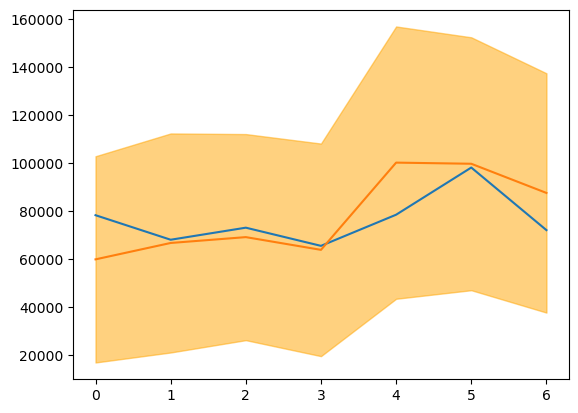

In [39]:
plt.plot(bet_df.index ,casino_fig['Total_Bets'][1087:1094] )
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')